In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import hdbscan
from bertopic import BERTopic

from sentence_transformers import SentenceTransformer, util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction


### Problem/Challange:

**Determining the similarity of companies has many important use-cases** <br>These include:

1) Accurately mapping out a competitive landscape

2) Grouping similar companies into industries and verticals to analyze them

3) Sourcing deals: finding comanpies that are similar to a description you input

However, defining "similarity" is extremely complex. As seen on the previous notebook, finding similar companies by 

- What is similarity?

Sentence Transformers: Multilingual Sentence Embeddings using BERT / RoBERTa / XLM-RoBERTa & Co. with PyTorch
This framework provides an easy method to compute dense vector representations for sentences and paragraphs (also known as sentence embeddings). The models are based on transformer networks like BERT / RoBERTa / XLM-RoBERTa etc. and are tuned specificially meaningul sentence embeddings such that sentences with similar meanings are close in vector space.

We provide an increasing number of state-of-the-art pretrained models for more than 100 languages, fine-tuned for various use-cases.

Further, this framework allows an easy fine-tuning of custom embeddings models, to achieve maximal performance on your specific task.

For the full documentation, see www.SBERT.net, as well as our publications:

Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks (EMNLP 2019)
Making Monolingual Sentence Embeddings Multilingual using Knowledge Distillation (EMNLP 2020)
Augmented SBERT: Data Augmentation Method for Improving Bi-Encoders for Pairwise Sentence Scoring Tasks (arXiv 2020)
The Curse of Dense Low-Dimensional Information Retrieval for Large Index Sizes (arXiv 2020)



- Solution using BERT

In [4]:
%%time
model = SentenceTransformer('stsb-roberta-large')

CPU times: user 5.15 s, sys: 5.26 s, total: 10.4 s
Wall time: 9.05 s


# Example of Company Desciption Similarity

In [5]:
input_description = ["Developer of an enterprise AI platform designed to accelerate data science by automating the end-to-end journey from data to value. The company's platform democratizes data science with end-to-end automation for building, deploying, and managing machine learning models, and maximizes business value by delivering AI at scale and continuously optimizing performance over time, thereby allowing clients to drive better business outcomes by deploying trusted AI applications within their organizations. "]

database_descriptions = ["Provider of an artificial intelligence platform designed to help organizations create large-scale, real-time customizable deep learning systems. The company's platform packages research on generative models and neural architecture search to deal with noisy or incomplete data and then finds the best neural network that models the specific dataset and use-case while also handling setting up of data pipelines, scheduled retraining of models from new data, enabling companies of all sizes, to easily and effortlessly embed cutting-edge deep learning models into their business processes, or customer experiences.",
                     
                     "Developer of artificial intelligence (AI) medical imaging platform designed to flag abnormalities as they enter the radiology worklist. The company's platform detect and pinpoint critical anomalies for radiologists through deep learning and AI algorithms that analyze medical images and patient data, enabling radiologists to produce accurate scan anomaly detection.",
                     
                     "Provider of talent management services dedicated to helping organizations navigate change and transform their workforce. The company's platform uses artificial intelligence and machine learning to assess the workforce's knowledge, qualifications and skills as well as training services, thus enabling enterprises and Government agencies to retrain, recruit and retain workers faster and more accurately.", 
                     
                     "Provider of a genome editing biotechnology platform intended to offer products and services to academia, biotechnology and pharmaceutical companies. The company's platform aims to translate genome editing technologies into novel therapeutics for genetic diseases and cancer, enabling drug discovery companies to conduct high-throughput genome screening and detection of functional big data in biological contexts.",
                     
                     "Operator of a biotechnology company focused on developing precision medicines for genetically defined neurological and immunological diseases. The company leverages recent advances in human genetics, combined with their state-of-the-art artificial intelligence (AI)-enabled drug discovery and biomarker platforms, to advance therapeutics for devastating diseases, providing patients with the right medicines suffering from genetic disorders."
]

#Compute embedding for list
database_embeddings = model.encode(database_descriptions, convert_to_tensor=True)
input_embedding = model.encode(input_description, convert_to_tensor=True)
input_embedding.shape

torch.Size([1, 1024])

In [6]:
#Compute cosine-similarits
cosine_scores = util.pytorch_cos_sim(input_embedding, database_embeddings)
print(cosine_scores)



tensor([[0.7061, 0.5215, 0.6263, 0.5047, 0.5612]])


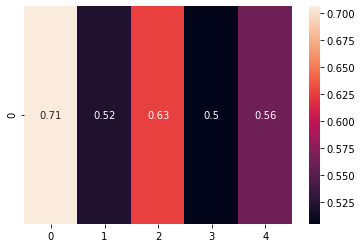

In [7]:
sns.heatmap(cosine_scores, annot=True);

In [8]:
#Double: Find the pairs with the highest cosine similarity scores
# pairs = []
# for i in range(len(cosine_scores)-1):
#     for j in range(i+1, len(cosine_scores)):
#         pairs.append({'index': [i+1, j+1], 'score': cosine_scores[i][j]})

# #Sort scores in decreasing order
# pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)
# pairs
# range(len(cosine_scores[0])-1)
#sinlge
pairs = []
for i in range(len(cosine_scores[0]-1)):
    pairs.append({'index': i, 'score': cosine_scores[0][i]})

# Sort scores in decreasing order
pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)

pairs
del pairs[0]

print(pairs)

list(pairs)[0].keys()




[{'index': 2, 'score': tensor(0.6263)}, {'index': 4, 'score': tensor(0.5612)}, {'index': 1, 'score': tensor(0.5215)}, {'index': 3, 'score': tensor(0.5047)}]


dict_keys(['index', 'score'])

In [9]:
from modules.semantics import Semantic
import pickle

In [10]:
data = pd.read_excel('Investments2020_.xlsx')
data.head()

,Company Name,Last Financing Deal Type,Last Financing Deal Type 2,Last Financing Size,Last Financing Valuation,Total Raised,Last Financing Date,Primary Industry Group,Primary Industry Sector,All Industries,Verticals,HQ Location,Year Founded,Active Investors,Keywords,Website,Description,Primary Contact,Primary Contact Email
0,100Plus,Seed Round,Seed Round,15.0,NaN,15.00,2020-04-24,Healthcare Devices and Supplies,Healthcare,"Diagnostic Equipment*, Electronics (B2C), Medi...","Digital Health, TMT, Wearables & Quantified Self","San Francisco, CA",2016.0,"8VC, Ali Partovi, Ammunition Design Group, Ban...","heart monitor, heart monitoring device, remote...",www.100plus.com,Developer of remote patient monitoring platfor...,Ryan Howard,ryan@100plus.com
1,1upHealth,Early Stage VC,Series A,8.0,30.0,10.35,2020-02-05,Healthcare Technology Systems,Healthcare,"Medical Records Systems*, Other Healthcare Ser...","Digital Health, HealthTech, TMT","Boston, MA",2017.0,"Advisors.Fund, Boston Children's Hospital, Eni...","clinical hospital data, fhir api platform, hea...",www.1up.health,Developer of a healthcare data platform design...,Ritwik Sahu,rsahu@1up.health
2,Abacus.AI,Early Stage VC,Series B,22.0,102.0,40.25,2020-10-23,Commercial Services,Business Products and Services (B2B),"Business/Productivity Software, IT Consulting ...","Artificial Intelligence & Machine Learning, Bi...","San Francisco, CA",2019.0,"Avichal Garg, Coatue Management, Decibel Partn...","artificial intelligence platform, artificial i...",www.abacus.ai,Provider of an artificial intelligence platfor...,Bindu Reddy,bindu@abacus.ai
3,Able.,Later Stage VC,Series B,7.0,20.0,11.50,2020-02-10,Software,Information Technology,"Business/Productivity Software*, Human Capital...","HR Tech, Mobile, SaaS","Cleveland, OH",2014.0,"JumpStart, M25, North Coast Ventures, Ohio Inn...","hiring platform, interview screening, online h...",www.ableteams.com,Developer of a cloud-based onboarding and cand...,Gerald Hetrick,gerald@employstream.com
4,Abnormal Security,Early Stage VC,Series B,50.0,600.0,74.00,2020-11-18,Software,Information Technology,Network Management Software*,"Artificial Intelligence & Machine Learning, Cy...","San Francisco, CA",2018.0,"Greylock Partners, Menlo Ventures","business email security, email fraud security,...",www.abnormalsecurity.com,Developer of a cloud email security platform d...,Evan Reiser,evan@abnormalsecurity.com


In [11]:
descriptions = data.Description.to_list()
descriptions = descriptions[:850]

In [114]:
%%time

semantic = Semantic(model, descriptions)

CPU times: user 10min 27s, sys: 26.6 s, total: 10min 53s
Wall time: 10min 19s


In [132]:
np.savez("embeddings.npz", semantic.embeddings)

In [17]:
embeddings = np.load('embeddings.npz')['arr_0']
embeddings.shape

(850, 1024)

In [19]:
semantic = Semantic(model)
semantic.embeddings = embeddings
semantic.embeddings

array([[ 0.6024779 , -0.16250448, -0.6117225 , ...,  1.4368169 ,
         0.08835882, -0.5506266 ],
       [-1.2839003 ,  0.22017166, -0.5549152 , ...,  1.0786262 ,
         0.38651848, -0.11077125],
       [ 0.12822537,  0.19735853, -0.26729053, ...,  1.1787283 ,
        -1.3760625 ,  0.19986163],
       ...,
       [ 0.1822463 ,  0.19776478, -0.33034015, ...,  1.4761724 ,
        -0.2730261 , -0.3134724 ],
       [ 0.826726  ,  0.16342044,  0.5628858 , ...,  0.6087018 ,
        -0.3602691 , -0.6966098 ],
       [ 0.33552667,  0.45197478, -0.10969167, ...,  1.3269372 ,
         0.6223505 ,  0.18609147]], dtype=float32)

In [25]:
groups = semantic.community_detection(threshold=0.75, init_max_size=10)
print(len(groups))
print(groups)

9
[[15, 19, 50, 112, 116, 142, 151, 160, 185, 197, 216, 247, 276, 288, 300, 320, 358, 395, 413, 435, 462, 474, 536, 538, 563, 567, 577, 625, 635, 641, 787, 790, 841], [34, 51, 70, 123, 129, 166, 211, 251, 302, 334, 387, 489, 491, 509, 537, 548, 552, 560, 566, 606, 620, 643, 692, 731, 742, 763], [2, 39, 59, 144, 196, 238, 280, 286, 333, 398, 417, 440, 514, 562, 568, 621, 695, 745, 751, 775, 810], [3, 46, 106, 158, 234, 285, 332, 428, 500, 584, 650, 658, 783, 814], [141, 182, 222, 241, 411, 415, 438, 467, 473, 565, 574, 593, 682, 729], [56, 128, 233, 239, 294, 307, 330, 455, 511, 551, 752, 780, 827], [64, 73, 165, 198, 227, 242, 362, 513, 521, 591, 626, 684, 706], [9, 95, 119, 301, 410, 430, 448, 588, 679, 836], [16, 243, 295, 434, 592, 612, 697, 698, 699, 700]]


In [29]:
for x in data.iloc[groups[0]].Description:
    print(x)
    print()


Developer of spend management software platform designed to give support to growing companies. The company's platform combines expense approvals, physical and virtual cards, bill payments, reporting, and accounting automation into a single, intuitive platform, enabling companies to get full control and visibility into their spending, automate accounting processes and make purchasing painless for employees.

Developer of cross-border payments and foreign exchange platform designed to make and receive international payments. The company's platform effortlessly integrates into an ecosystem of the application program interface, products, automation, global networks, and local payment systems to create a scalable tool, enabling clients, suppliers, and institutions to issue and pay invoices in their preferred currency at the mid-market foreign exchange rate.

Developer of a procurement management platform designed to streamline operations. The company's platform provides control and visibili

In [30]:
desc = "Deci develops AI technology to build and operate AI models. Deci's deep-learning platform enables data scientists to transform their AI models into production-grade solutions on any hardware. Deci's proprietary Automated Neural Architecture Construction technology autonomously redesigns an enterprise's deep-learning models to squeeze the maximum utilization out of its hardware.Deci aims to eliminate production-related bottlenecks across the AI lifecycle to allow developers and engineers to create innovative AI solutions for complex problems."

df_test = semantic.find_topk_related(desc, threshold=0.75)
df_test = df_test[:10]["index"]
df_test
new_data = data.iloc[df_test]

for x in new_data.Description:
    print(x)
    print()

Developer of AI and deep learning platform designed to craft the next generation of AI. The company's deep learning platform and its proprietary Automated Neural Architecture Construction (AutoNAC) technology autonomously redesigns an enterprise's deep learning models to squeeze the maximum utilization out of its hardware, enabling data scientists to transform their AI models into production-grade solutions.

Developer of a cloud-based digital manufacturing platform intended to make industrial automation easier and more accessible. The company's platform consists of a library of structural, motion, and control components, a free cloud-based 3D machine builder, and artificial intelligence-enabled 3D constraints, enabling manufacturing companies to design, program, simulate, order and commission automated equipment directly from a single digital environment.

Developer of imaging and artificial intelligence solutions intended for autonomous robots. The company offers to sense technology 